## Домашнее задание 6, Ускорение и оптимальные методы

### Deadline - 25.10.2024    23:59

# Подготовительная часть

Как и ранее, рассмотрит задачу минимизации эмпирического риска:

\begin{equation}
\min_{x \in \mathbb{R}^d} \left[ f(x) = \frac{1}{n} \sum\limits_{i=1}^n \ell_x(a_i, b_i) + \frac{\lambda}{2} \| x \|^2_2\right],
\end{equation}

где:
- $\ell_x(a_i, b_i)$ — функция потерь (cross-entropy loss),
- $x$ — вектор параметров модели,
- $\{a_i, b_i\}_{i=1}^n$ — выборка данных,
- $\lambda > 0$ — параметр регуляризации.

Функция потерь для каждого объекта $i$ записывается как:

\begin{equation}
\ell_x(a_i, b_i) = -b_i \ln(p(x^Ta_i)) - (1 - b_i) \ln(1 - p(x^Ta_i)),
\end{equation}

где $p(x^Ta_i)$ — это вероятность, вычисляемая с помощью логистической функции в комбинации с линейной моделью:

\begin{equation}
p(x^Ta_i) = \frac{1}{1 + \exp(-x^T a_i)}.
\end{equation}




К заданию приложен датасет _mushrooms_. С помощью следующего кода сформируйте матрицу $A$ и вектор $b$, в которой и будет храниться выборка $\{a_i, b_i\}_{i=1}^n$. 

In [35]:
from sipbuild.generator.parser.rules import p_struct_head

dataset = "mushrooms.txt"
#файл должен лежать в той же деректории, что и notebook

In [36]:
from sklearn.datasets import load_svmlight_file

data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

Поменяем вектор $y$, чтобы $y_i$ принимали значения $0$ и $1$. Вы также можете сделать дополнительную предобработку данных (приемами из машинного обучения), но это никак дополнительно не оценивается.

In [37]:
b = b - 1

Разделим данные на две части: обучающую и тестовую.

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np
import scipy

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=GLOBAL_SEED)

Для обучающей части $A_{train}$, $b_{train}$ оцените константу $L$. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.  Реализуйте в коде подсчет значения градиента для нашей целевой функции ($A$, $b$, $\lambda$ лучше подавать в качестве параметра, чтобы была возможность их менять, а не только подставлять фиксированные $A_{train}$, $b_{train}$). Можно использовать как библиотеку ``numpy``, так и библиотеки ``autograd``, ``pytorch``, ``jax``. Воспользуйтесь кодом с предыдущего домашнего задания.

In [39]:
def get_params(A_):
    L_ = (1000 * np.linalg.eigvals(A_.T @ A_).max().real) / (999 * 4 * A_.shape[0])
    return L_, L_ / 1000


def get_grad_func(A_, b_, lambda_reg_):
    def grad(x):
        p_ = scipy.special.expit(x.T @ A_.T)
        f_val = 0  #(-np.log(p_) @ b_ - np.log(1 - p_) @ (1 - b_) + lambda_reg * x.T @ x) / A_.shape[0]
        fg_val = ((p_ - b_) @ A_ / A_.shape[0]).T + lambda_reg * x
        fgg_val = p_ * (1 - p_) * A_.T @ A_ / A_.shape[0] + lambda_reg_ * np.eye(A_.shape[1])
        return f_val, fg_val, fgg_val

    return grad

## Основная часть (всего 5 баллов) 

__Задача 1. (всего 2.5 балла)__ Метод Ньютона (классический и демпфированный)

Рассмотрим один из самых известных методов второго порядка - Метод Ньютона (Newton's method). А точнее его модификацию - демпфированный метод Ньютона (Dumped Newton's method, DNM). 

**Псевдокод алгоритма**

_Инициализация:_

Величина шага $\{\gamma_k \}_{k=0} > 0$, стартовая точка $ x^0 \in \mathbb{R}^d $, количество итераций $ K $

$k$_-ая итерация:_
1. Подсчитать направление спуска $$ d_k = \left(\nabla^2 f(x^k) \right)^{-1} \nabla f(x_k)  $$
2. Сделать шаг алгоритма $$ x^{k+1} = x^k - \gamma_k d_k $$

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

Как нетрудно заметить, при $\gamma_k \equiv 1$ демпфированный метод вырождается в классический (который, наверное, вам известен из вычислительной математики). 

### Указание: поставьте во всех методах точность по умолчанию равной $10^{-16}$.

__а) (0.25 балла)__ Для метода Ньютона нам нужно будет использовать значение гессиана функции потерь. Воспользуясь знаниями, полученными ранее, докажите, что градиент и гессиан равны, соответственно
$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (p(x^Ta_i) - b_i) a_i + \lambda x \qquad \qquad \nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n \big(p(x^Ta_i)(1 - p(x^Ta_i))\big) a_i a_i^T + \lambda I_d
$$

__Ваше решение__

$df(x) = d \left( \frac{1}{n} \sum\limits_{i=1}^n \ell_x(a_i, b_i) + \frac{\lambda}{2} \|x\|^2_2 \right) = 
\frac{1}{n} \sum\limits_{i=1}^n d \left( -b_i \ln(p(x^Ta_i)) - (1 - b_i) \ln(1 - p(x^Ta_i))\right)  + \frac{\lambda}{2} \langle x, x \rangle = 
\frac{1}{n} \sum\limits_{i=1}^n \left(-b_i \frac {d(p(x^T a_i))}{p(x^T a_i)} + (1 - b_i) \frac {d(p(x^T a_i))} {1 - p(x^T a_i)} \right) + \lambda \langle x, dx \rangle = 
\frac{1}{n} \sum\limits_{i=1}^n \left( \frac{(p(x^Ta_i) - b_i)d(p(x^Ta_i))}{p(x^Ta_i)(1 - p(x^Ta_i))} + \lambda \langle x, dx \rangle \right) = 
\frac{1}{n} \sum\limits_{i=1}^n \left( \frac{(p(x^Ta_i) - b_i)}{p(x^Ta_i)(1 - p(x^Ta_i))} \cdot \left( \frac{1}{1 + \exp(-x^T a_i)} \right)^2 \cdot \exp(-x^T a_i) \cdot d(x^T a_i) \right) + \lambda \langle x, dx \rangle  = 
\frac{1}{n} \sum\limits_{i=1}^n \left( \frac{(p(x^Ta_i) - b_i)}{p(x^Ta_i)(1 - p(x^Ta_i))} \cdot \left(  \frac{1}{1 + \exp(-x^T a_i)}  - \left( \frac{1}{1 + \exp(-x^T a_i)} \right)^2 \right) \cdot d \langle a_i, x \rangle \right)  + \lambda \langle x, dx \rangle = 
\frac{1}{n} \sum\limits_{i=1}^n \left( \frac{(p(x^Ta_i) - b_i)}{p(x^Ta_i)(1 - p(x^Ta_i))} \cdot \left( p(x^Ta_i)(1 - p(x^Ta_i)) \right) \cdot \langle a_i, dx \rangle \right) + \lambda \langle x, dx \rangle  = 
\langle \frac{1}{n} \sum_{i=1}^n (p(x^Ta_i) - b_i) a_i + \lambda x, dx \rangle \Rightarrow $
$$ \nabla f(x) = \frac{1}{n} \sum_{i=1}^n (p(x^Ta_i) - b_i) a_i + \lambda x $$

$d(\nabla f(x)) = d(\frac{1}{n} \sum_{i=1}^n (p(x^Ta_i) - b_i) a_i + \lambda x) = \frac{1}{n} \sum_{i=1}^n d \left((p(x^Ta_i) - b_i) a_i \right) + \lambda dx = 
 \frac{1}{n} \sum_{i=1}^n \left(p(x^Ta_i) \cdot(1 - p(x^Ta_i)) a_i \right) d(x^T a_i) + \lambda dx = 
 \frac{1}{n} \sum_{i=1}^n \left(p(x^Ta_i) \cdot(1 - p(x^Ta_i)) a_i \right) d(a_i^T x) + \lambda dx  =
 \left( \frac{1}{n} \sum_{i=1}^n p(x^Ta_i) (1 - p(x^Ta_i)) a_i a_i^T+ \lambda \right) dx \Rightarrow$

 $$H(x) = \frac{1}{n} \sum_{i=1}^n \bigl(p(x^Ta_i)(1 - p(x^Ta_i))\bigr) a_i a_i^T + \lambda I$$

__б) (0.25 балла)__ Запустите демпфированный метод Ньютона для задачи логистической регрессии. Пусть $x_0 = 0$. Постройте график зависимости критерия от числа итераций (```max_iter``` поставьте не больше 10). Сходится ли метод?

In [40]:
import numpy as np
from tqdm import trange


def DumpedNewton(grad, criterion, x_0, eps, max_iter, **params):
    """
       :param grad: функция, которая считает градиент целевой функции;
       :param criterion: функция, считающаф критерий;
       :param x_0: начальная точка;
       :param eps: точность сходимости (обычно 1e-8);
       :param max_iter: количество итераций;
       :param params['gamma'] - шаг;
    """

    errors = []

    x_k = np.copy(x_0)
    err_x_0 = criterion(x_k)

    errors.append(criterion(x_k) / err_x_0)

    for k in trange(max_iter):
        f, fg, fgg = grad(x_k)
        d_k = np.linalg.inv(fgg) @ fg
        x_k -= d_k * params['gamma'](k)

        errors.append(criterion(x_k) / err_x_0)

        if errors[-1] < eps:
            break

    return x_k, errors

In [41]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from typing import Tuple

sns.set_theme(palette='Set2', rc={'figure.figsize': (16, 9)})
matplotlib.rcParams['figure.figsize'] = (16, 9)


def make_plot(xlabex: str, ylabel: str, title: str = "Plot", xlim: Tuple[float, float] = None,
              ylim: Tuple[float, float] = None, xscale: str = "linear", yscale: str = "linear", **kwargs) -> (
        plt.figure, plt.axis):
    """
    Creates a plot with parameters
    
    :param xlabex: x-axis label
    :param ylabel: y-axis label
    :param title: plot title
    :param xlim: x-limits
    :param ylim: y-limits
    :param xscale: scale of X-axis 
    :param yscale: scale of Y-axis
    """
    fig_, axs_ = plt.subplots(**kwargs)

    axs_.set_xlabel(xlabex)
    axs_.set_ylabel(ylabel)
    axs_.set_title(title)
    axs_.set_xscale(xscale)
    axs_.set_yscale(yscale)

    if xlim is not None:
        axs_.set_xlim(xlim)
    if ylim is not None:
        axs_.set_ylim(ylim)

    return fig_, axs_


In [42]:
EPS = 1e-16
MAX_ITER = 10
gamma = [0.5, 1, 1.5, 2]

L, lambda_reg = get_params(A_train)
grad = get_grad_func(A_train, b_train, lambda_reg)
crit = lambda x_k: np.linalg.norm(grad(x_k)[1])

x0_keys = {'0': rf"$\overrightarrow{{0}}$",
           '1': rf"$\overrightarrow{{1}}$"}

x0 = {"0": np.zeros((A_train.shape[1], 1)),
      "1": np.ones((A_train.shape[1], 1))}
for i in range(1, 9):
    x0_keys[f"e{i}"] = rf"$\overrightarrow{{e_{{{i}}}}}$"
    x0[f"e{i}"] = (np.arange(0, A_train.shape[1], 1) <= i).astype(float).reshape(-1, 1)

errorsNewton = {"0": DumpedNewton(grad, crit, x0["0"], EPS, MAX_ITER, gamma=lambda _: 1.2, flag=False)[1]}

100%|██████████| 10/10 [00:00<00:00, 15.46it/s]


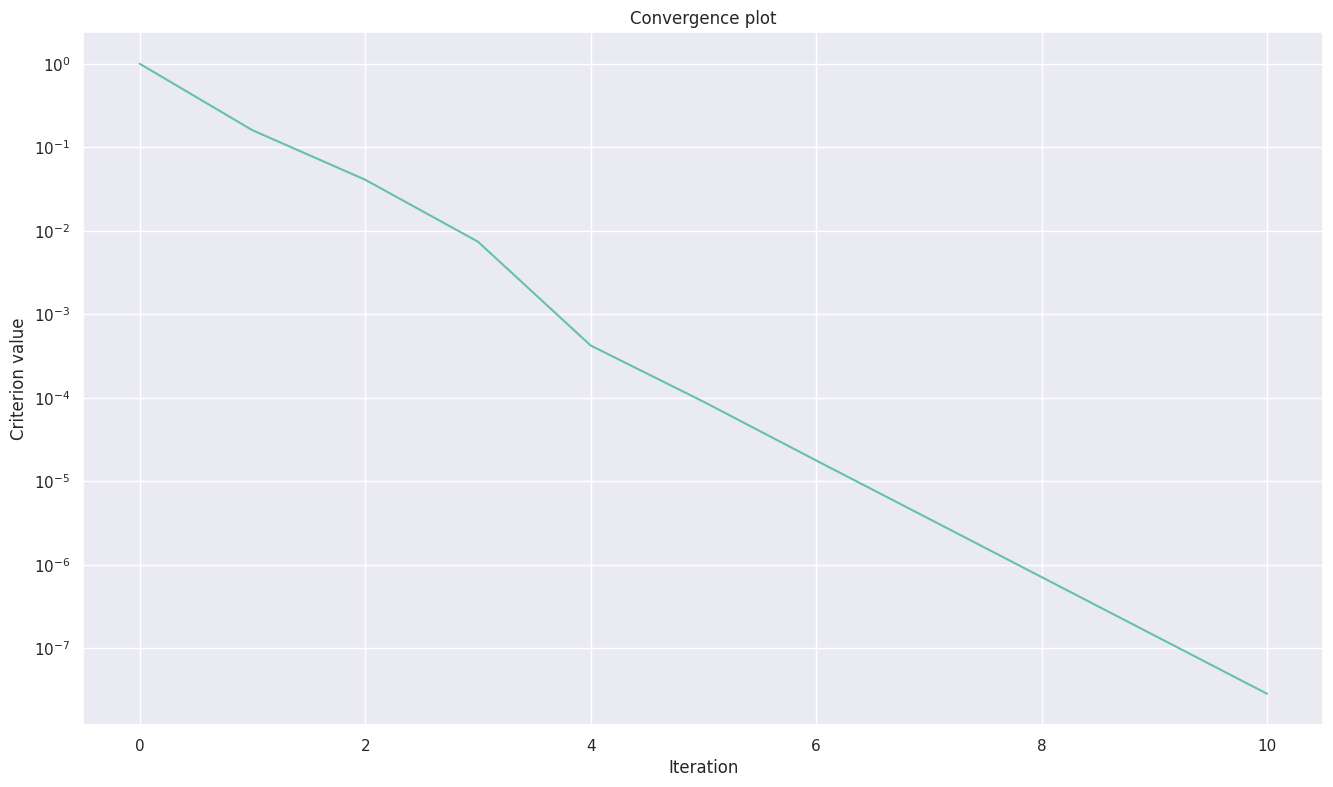

In [43]:
_, axs = make_plot(xlabex="Iteration", ylabel="Criterion value", title="Convergence plot", yscale="log")
sns.lineplot(x=np.arange(0, len(errorsNewton["0"])), y=errorsNewton["0"], ax=axs)
plt.show()

__в) (0.25 балла)__ Зафиксировав значение $\gamma_k=1$, рассмотрите следующие значения парметра $x_0$:
1. Вектор из 0;
2. Вектор из 1;
3. Вектора $\vec{e}_i$ ($i = 1, 2, \ldots , 8$), $j$-ая координата которых подчиняется следующему правилу:
$$  \left[ \vec{e}_i \right]_j = \begin{cases} i, & \text{если } j \leq i \\ 0, &\text{иначе} \end{cases}$$

Постройте графики зависимости критерия от числа итераций.

In [44]:
errorsNewton = {}
for key, val in x0.items():
    errorsNewton[key] = DumpedNewton(grad, crit, val, EPS, MAX_ITER, gamma=lambda _: gamma[1], flag=True)[1]

 70%|███████   | 7/10 [00:00<00:00, 22.80it/s]


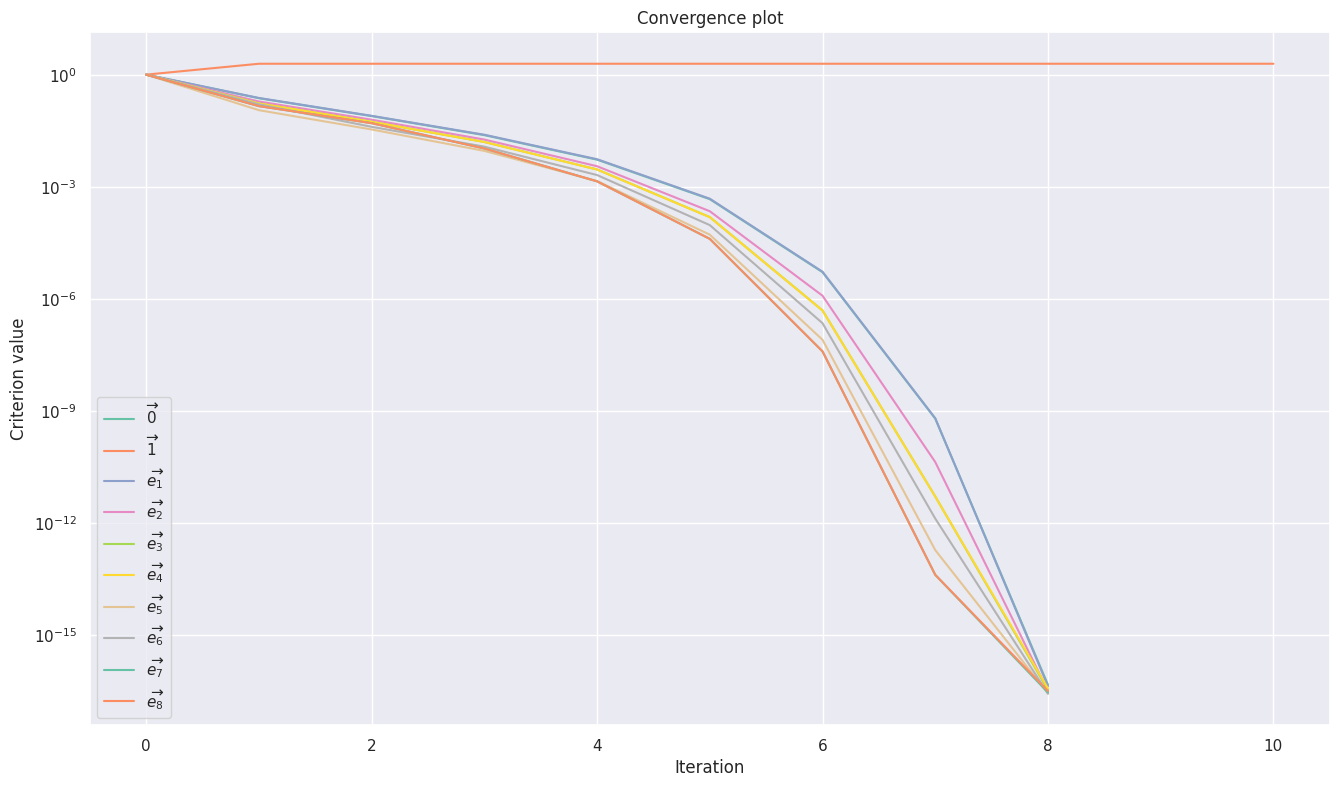

In [45]:
_, axs = make_plot(xlabex="Iteration", ylabel="Criterion value", title="Convergence plot", yscale="log")
for key, val in errorsNewton.items():
    sns.lineplot(x=np.arange(0, len(val)), y=val, label=x0_keys[key], ax=axs)

__г) (0.5 балла)__ Выберите и зафиксируйте произвольное значение $x_0$ из предыдущего пункта, для которого наблюдается сходимость DNM. Теперь исследуем зависимость сходимости от параметра $\gamma_k$. Для этого проверьте следующие значения $\gamma_k = \{ 0.5, 1, 1.5, 2 \}$. Постройте графики зависимости критерия от числа итераций.

Зафиксируем $\overrightarrow{e_{8}}$

In [46]:
errorsNewton = {}
for val in gamma:
    errorsNewton[val] = DumpedNewton(grad, crit, x0["e8"], EPS, MAX_ITER, gamma=lambda _: val, flag=False)[1]

100%|██████████| 10/10 [00:00<00:00, 10.89it/s]


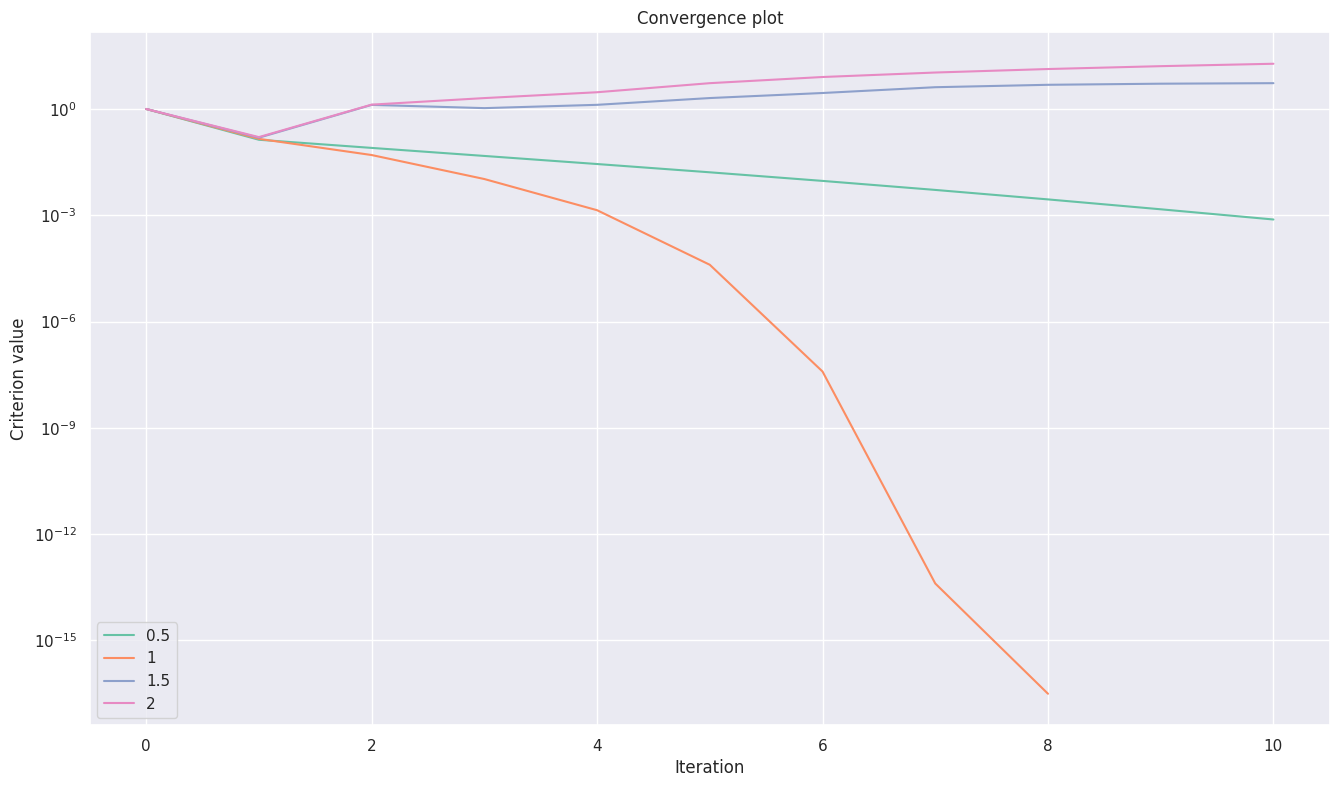

In [47]:
_, axs = make_plot(xlabex="Iteration", ylabel="Criterion value", title="Convergence plot", yscale="log")
for key, val in errorsNewton.items():
    sns.lineplot(x=np.arange(0, len(val)), y=val, label=key, ax=axs)

__д) (0.75 балла)__ Давайте теперь вызовем несколько итераций метода градиентного спуска, перед использованием демпфированного метода Ньютона (воспользуйтесь результатами предыдущих домашек). Варьируя число итераций градиентного спуска (возьмите 10, 20, 50, 100), исследуйте сходимость метода DNM при фиксированных значениях $x_0$ (возьмите вектор из единиц) и $\gamma_k = 1$. 

In [48]:
import numpy as np


def GradientDescent(grad, criterion, x_0, eps, max_iter, **params):
    """
    :param grad: функция, которая считает градиент целевой функции;
    :param criterion: функция, вычисляющая критерий;
    :param x_0: начальная точка;
    :param eps: точность сходимости (обычно 1e-8);
    :param max_iter: количество итераций;
    :param params['gamma'](k) - шаг, зависящий от номера итерации.
    """

    errors = []

    x_k = np.copy(x_0)
    err_x_0 = criterion(x_k)
    errors.append(criterion(x_k) / err_x_0)

    for k in trange(max_iter):
        x_k -= params["gamma"](k) * grad(x_k)[1]

        errors.append(criterion(x_k) / err_x_0)
        if errors[-1] < eps:
            break

    return x_k, errors


def NewtonGD(grad, criterion, x_0, eps, max_iter, **params):
    """
    :param grad: функция, которая считает градиент целевой функции;
    :param criterion: функция, вычисляющая критерий;
    :param x_0: начальная точка;
    :param eps: точность сходимости (обычно 1e-8);
    :param max_iter: количество итераций метода Ньютона;
    :param params['max_iter_gd'] - количество итераций градиентного спуска;
    :param params['gamma_gd'](k) - шаг градиентного спуска, зависящий от номера итерации.
    :param params['gamma'](k) - шаг метода Ньютона, зависящий от номера итерации.
    """

    x_0_ = GradientDescent(grad, criterion, x_0, eps, params['max_iter_gd'], gamma=params['gamma_gd'])[0]
    return DumpedNewton(grad, criterion, x_0_, eps, max_iter, gamma=params['gamma'])

In [49]:
descent_iter = [10, 20, 50, 100]

errorsNewtonGD = {}
for val in descent_iter:
    errorsNewtonGD[val] = \
        NewtonGD(grad, crit, x0["1"], EPS, MAX_ITER, gamma=lambda _: 1, max_iter_gd=val, gamma_gd=lambda _: 1 / L,
                 flag=False)[1]

100%|██████████| 10/10 [00:00<00:00, 44.54it/s]


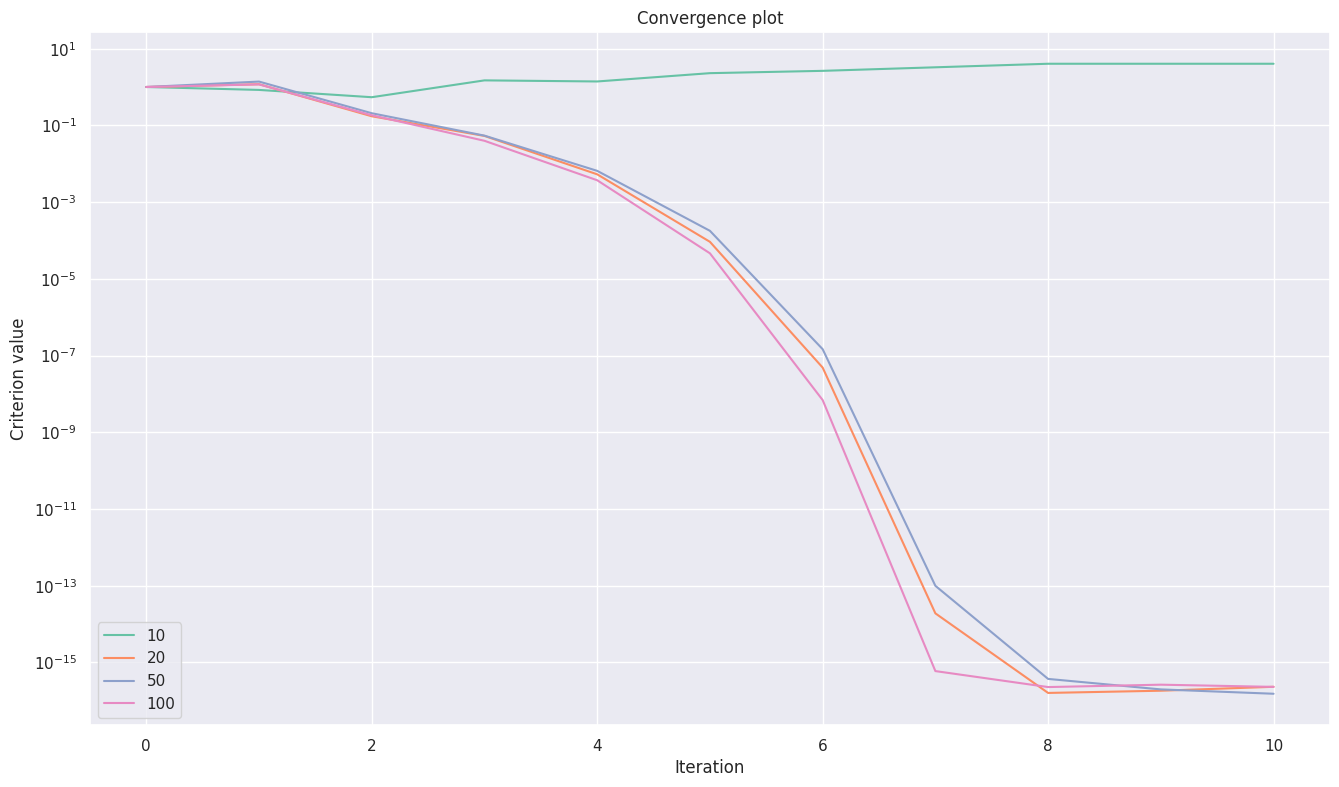

In [50]:
_, axs = make_plot(xlabex="Iteration", ylabel="Criterion value", title="Convergence plot", yscale="log")
for key, val in errorsNewtonGD.items():
    sns.lineplot(x=np.arange(0, len(val)), y=val, label=key, ax=axs)

__е) (0.25 балла)__ Теперь рассмотрим датасет ```w8a.txt```. Его размеры несколько больше, чем у ```mushrooms.txt``` (сравните, насколько), поэтому вычисление гессиана будет занимать больше времени. Повторите предыдущий пункт, используя те же значения для количества предварительных шагов градиентного спуска, а число итераций демпфированного метода Ньютона положите равной 5.

In [51]:
dataset = "w8a.txt"

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

data2 = load_svmlight_file(dataset, )
A2, b2 = data2[0].toarray(), data2[1]

A2_train, A2_test, b2_train, b2_test = train_test_split(A2, b2, test_size=0.2, random_state=GLOBAL_SEED)

In [52]:
print(f"Размер грибов: {len(A_train)}")
print(f"Размер w8a: {len(A2_train)}")
print(f"Отношение размеров: {len(A2_train) / len(A_train):.2f}")

Размер грибов: 6499
Размер w8a: 39799
Отношение размеров: 6.12


In [53]:
MAX_ITER = 5
L, lambda_reg = get_params(A2_train)
grad = get_grad_func(A2_train, b2_train, lambda_reg)
crit = lambda x_k: np.linalg.norm(grad(x_k)[1])
x0 = (np.arange(0, A2_train.shape[1], 1) <= 8).astype(float).reshape(-1, 1)

descent_iter = [10, 20, 50, 100]

for val in descent_iter:
    errorsNewtonGD[val] = \
        NewtonGD(grad, crit, x0, EPS, MAX_ITER, gamma=lambda _: 1, max_iter_gd=val, gamma_gd=lambda _: 1 / L,
                 flag=False)[1]

 60%|██████    | 3/5 [00:01<00:01,  1.83it/s]


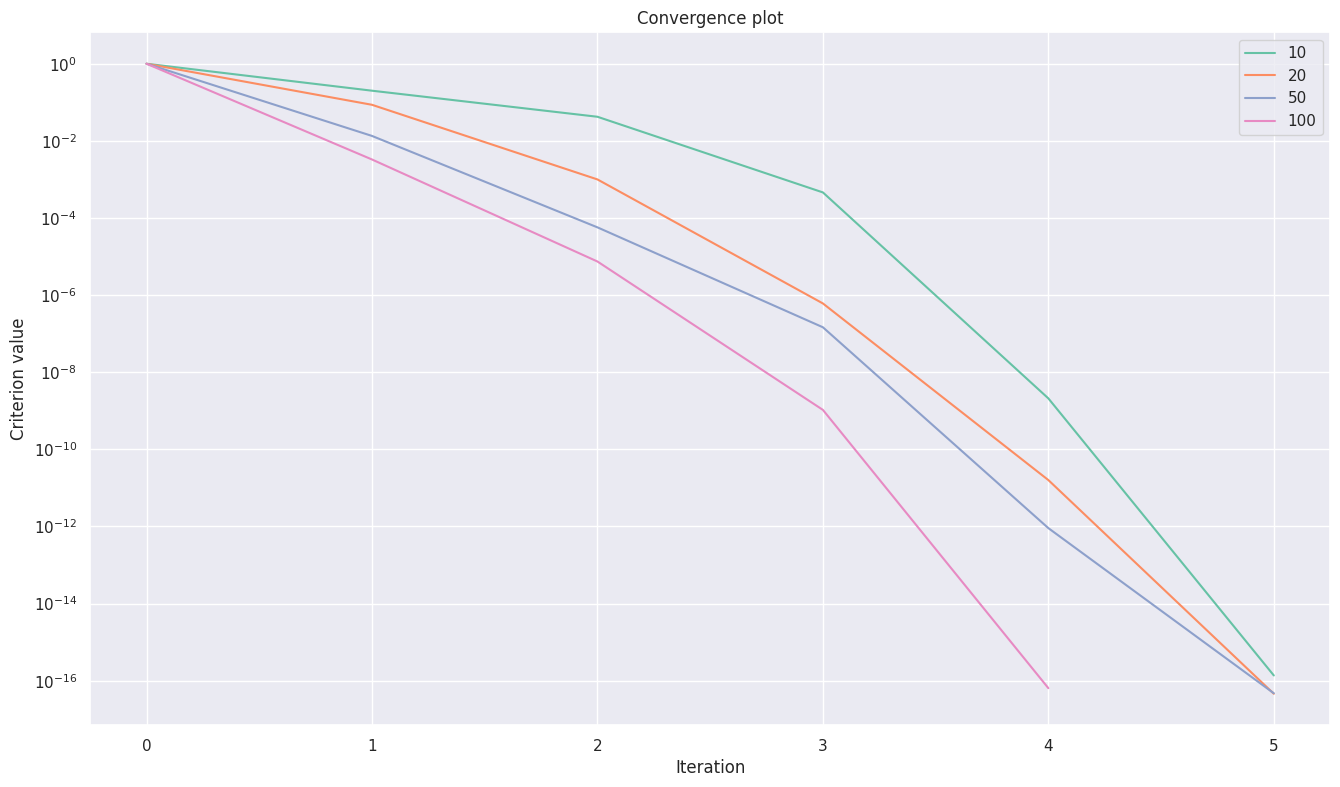

In [54]:
_, axs = make_plot(xlabex="Iteration", ylabel="Criterion value", title="Convergence plot", yscale="log")
for key, val in errorsNewtonGD.items():
    sns.lineplot(x=np.arange(0, len(val)), y=val, label=key, ax=axs)

__ё) (0.25 балла)__ В данном пункте нужно будет сравнить временную сложность алгоритмов первого порядка (```GradientDescent, HeavyBall, NAG```) и предложенных в данной домашней работе реализаций метода Ньютона (```DumpedNewton``` и связку ```GradientDescent + DumpedNewton```). Для всех методов выберите $x_0 = 0$, $\varepsilon = 10^{-16}$ и следующие значения параметров:
1. ```GradientDescent```: max_iter = 3000, $\gamma_k = 1/L$;
2. ```HeavyBall```: max_iter = 3000, $\gamma_k = 1/L$, $\tau_k = 0.9$;
3. ```NAG```: max_iter = 3000, $\gamma_k = 1/L$, $\tau_k = 0.9$;
4. ```DumpedNewton```: max_iter = 8, $\gamma_k = 1$;
5. ```GradientDescent + DumpedNewton```: число шагов градиентного спуска - 100, число шагов метода Ньютона - 5, параметры методов такие же, как в пунктах 1 и 4.

Сделайте вывод о применимости метода Ньютона.


In [21]:
import timeit


def HeavyBall(grad, criterion, x_0, eps, max_iter, **params):
    """
       :param: grad - функция, которая считает градиент целевой функции;
       :param: criterion(x) - функция, считающая критерий;
       :param: x_0 - начальная точка;
       :param: eps - точность сходимости (обычно 1e-8);
       :param: max_iter - количество итераций;
       :param: **params - содержит именованные гиперпараметры метода:
       :param: params['gamma'](k) - шаг, зависящий от номера итерации,
       :param: params['tau'](k) - моментум, зависящий от номера итерации.
    """

    errors = []

    x_k = np.copy(x_0)
    x_k_prev = np.copy(x_0)

    err_x_0 = criterion(x_k)
    errors.append(criterion(x_k) / err_x_0)

    for k in trange(max_iter):
        x_k_next = x_k - params['gamma'](k) * grad(x_k)[1] + params['tau'](k) * (x_k - x_k_prev)
        x_k_prev, x_k = x_k, x_k_next

        errors.append(criterion(x_k) / err_x_0)
        if errors[-1] < eps:
            break

    return x_k, errors


def NAG(grad, criterion, x_0, eps, max_iter, **params):
    """
       :params grad - функция, которая считает градиент целевой функции;
       :params criterion - функция, считающая критерий;
       :params x_0 - начальная точка;
       :params eps - точность сходимости (обычно 1e-8);
       :params max_iter - количество итераций;
       :params params['gamma'](k) - шаг, зависящий от номера итерации,
       :params params['tau'](k) - моментум, зависящий от номера итерации.
    """
    errors = []

    x_k = np.copy(x_0)
    y_k = np.copy(x_0)
    err_x_0 = criterion(x_k)
    errors.append(criterion(x_k) / err_x_0)

    for k in trange(max_iter):
        x_k_next = y_k - params["gamma"](k) * grad(y_k)[1]
        y_k_next = x_k_next + params["tau"](k) * (x_k_next - x_k)
        x_k, y_k = x_k_next, y_k_next

        errors.append(criterion(x_k) / err_x_0)
        if errors[-1] < eps:
            break
    return x_k, errors


def evaluate(func, *args, **kwargs):
    start = timeit.default_timer()
    return func(*args, **kwargs)[1][-1], timeit.default_timer() - start

In [22]:
GAMMA = [1 / L, 1 / L, 1 / L, 1, 1]
MAX_ITER = [3000, 3000, 3000, 8, 5]
methods = [GradientDescent, HeavyBall, NAG, DumpedNewton, NewtonGD]

scores = []
for i, method in enumerate(methods):
    scores.append(
        evaluate(method, grad, crit, x0, EPS, MAX_ITER[i], gamma=lambda _: GAMMA[i], tau=lambda _: 0.9, max_iter_gd=100,
                 gamma_gd=lambda _: 1 / L))

names = ["Gradient Descent", "Heavy Ball", "NAG", "Dumped Newton", "Gradient Descent + Dumped Newton"]

for i, score in enumerate(scores):
    print(f"{names[i]}:")
    print(f"--> Time: {score[1]}")
    print(f"--> Accuracy: {score[0]}\n")

 60%|██████    | 3/5 [00:01<00:00,  2.51it/s]

Gradient Descent:
--> Time: 669.98744205
--> Accuracy: 0.032544626620203944

Heavy Ball:
--> Time: 644.8755350459996
--> Accuracy: 1.6094775966827338e-14

NAG:
--> Time: 494.9169648770003
--> Accuracy: 3.745065569075511e-14

Dumped Newton:
--> Time: 0.7512871320004706
--> Accuracy: 2.939078043608102e-17

Gradient Descent + Dumped Newton:
--> Time: 21.040613113999825
--> Accuracy: 6.392768783461836e-17



__Задача 2. (всего 2.5 балла)__ Квазиньютоновские методы

Вычисление обратной матрицы Гесса является крайне ресурсоемким, поэтому предлагается использовать вместо ее точного значения некоторую аппроксимацию невырожденной положительно определенной матрицей. Такие методы называются *квазиньютоновскими*. В данной части будет предложен к рассмотрению один из самых популярных методов оптимизации.

__а) (0.5 балла)__ Реализуйте квазиньютоновский метод L-BFGS (см. [статью](https://users.iems.northwestern.edu/~nocedal/PDFfiles/limited-memory.pdf)), основанный на аппроксимации $H_k$. 

**Псевдокод алгоритма**

_Инициализация:_

Параметры линейного поиска $c_1, c_2$, аппроксимация обратного гессиана $H_0$, стартовая точка $ x^0 \in \mathbb{R}^d $, количество итераций $ K $

$k \hspace{-1em}$ _--ая итерация:_

1. Подсчитать направление спуска, используя аппроксимацию обратного гессиана $H_k$:
$$d_k = -H_k \nabla f(x_k).$$
2. Выполнить процедуру линейного поиска параметра $\alpha_k$, удовлетворяющего условиям Вольфе (см. [определение](https://en.wikipedia.org/wiki/Wolfe_conditions)):
$$\begin{align*}
f(x_k + \alpha_k d_k) &\leq f(x_k) + c_1 \alpha_k d_k^T \nabla f(x_k)\\
-d_k^T \nabla f(x_k + \alpha_k d_k)  &\leq -c_2 d_k^T \nabla f(x_k)
\end{align*}$$ 
3. Обновить $x_k$:
$$x_{k + 1} = x_k + \alpha_k d_k$$
4. Ввести $$\begin{align*} s_k &= x_{k + 1} - x_k \\ y_k &= \nabla f(x_{k + 1}) - \nabla f(x_k)\end{align*}$$ и обновить значение $H_k$:
$$
H_{k +1} = \left( I - \frac{y_k s_k^T}{y_k^T s_k} \right) H_k \left(  I - \frac{y_k^T s_k}{y_k s_k^T}  \right) + \frac{y_k y_k^T}{s_k s_k^T}
$$

*Замечание*: подумайте, как лучше инициализировать матрицу $H_0$. Функцию линейного поиска можно реализовать самостоятельно, а можете воспользоваться реализацией из библиотеки ```scipy.optimize```. 

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

In [23]:
from tqdm import trange
from scipy.optimize import line_search


def BFGS(f, grad, H_0, x_0, criterion, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H_0 - аппроксимация гессиана невырожденной положительно определенной матрицей;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['c_1'] - параметр в условие Вольфе, по умолчанию равен 0.0001
            params['c_2'] - параметр в условие Вольфе, по умолчанию равен 0.9
    '''
    errors = []

    err_x_0 = criterion(x_0)
    errors.append(criterion(x_0) / err_x_0)

    H_k = np.copy(H_0)

    x_k = np.array(x_0)
    x_new = np.array(x_0)

    g_k = grad(x_0)
    g_new = grad(x_0)

    I = np.eye(d)

    for k in trange(max_iter):

        # Ваше решение

        errors.append(criterion(x_new) / err_x_0)
        if errors[-1] < eps:
            break

    return x_new, errors

Вернемся к датасету ```mushrooms.txt```, для ускорения работы алгоритмов.

In [24]:
dataset = "mushrooms.txt"

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

b = 2 * b - 3

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=GLOBAL_SEED)

__б) (0.5 балла)__ Рассмотрите различные значения параметра $x_0$, как в пункте __1б)__. Число итераций поставьте равным 150. Постройте график зависимости критерия от номера итерации. Проведите сравнение с подобными графиками для DNM.

In [25]:
# Ваше решение (Code)

__в) (0.75 балла)__ Однако, такое приближение гессианов не единственно. Реализуйте метод SR1 (Symmetric rank-1) (см. [статью](https://arxiv.org/pdf/2002.00657.pdf)) со следующим обновлением аппроксимации обратного гессиана:
$$
H_{k + 1} = H_k + \frac{(s_k - H_k y_k)(s_k - H_k y_k)^T}{(s_k - H_k y_k)y_k^T}.
$$

In [26]:
from tqdm import trange
from scipy.optimize import line_search


def SR1(f, grad, H_0, x_0, criterion, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H_0 - аппроксимация гессиана невырожденной положительно определенной матрицей;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['c_1'] - параметр в условие Вольфе, по умолчанию равен 0.0001
            params['c_2'] - параметр в условие Вольфе, по умолчанию равен 0.9
    '''
    errors = []

    err_x_0 = criterion(x_0)
    errors.append(criterion(x_0) / err_x_0)

    H_k = np.copy(H_0)

    x_k = np.array(x_0)
    x_new = np.array(x_0)

    g_k = grad(x_0)
    g_new = grad(x_0)

    for k in trange(max_iter):

        # Ваше решение

        errors.append(criterion(x_new) / err_x_0)
        if errors[-1] < eps:
            break

    return x_new, errors

__г) (0.75 балла)__ Теперь давайте сравним работу квазиньютоновских методов с ускоренным методом (возьмите NAG) и методом второго порядка (DumpedNewton). В качестве начальной точки выберите $x_0 = 0$. Постройте сравнительные графики зависимостей критерия от итерации и критерия от времени. Что можно сказать о применимости квазиньютоновских методов? 

In [27]:
# Ваше решение (Code + Markdown)

## Дополнительная часть (всего 5 баллов)

__Задача 3. (всего 5 баллов)__ Квазиньютоновские методы очень хороши, так как не требуют использование второго порядка гладкости. Однако, все равно приходится хранить приближения матрицы Гесса, что при больших размерностях задачи очень сильно влияет на асимптотику по памяти, делая ее квадратичной. Для оптимизации этой величины были представлены методы с представкой L- (L-BFGS, L-SR1), где L- означает limited memory.

__a) (1 балл)__ Реализуйте метод L-BFGS, использующий технику ограниченной памяти с асимптотикой $\mathcal{O}(n)$. Пусть разрешено использовать $m$ значений с предыдущих итераций. Тогда псевдокод на $k$-ой итерации:

**Псевдокод алгоритма**

_Инициализация:_

Параметры линейного поиска $c_1, c_2$, стартовая аппроксимация обратного гессиана $H_0^k$, стартовая точка $ x^0 \in \mathbb{R}^d $, количество итераций $ K $

$k \hspace{-1em}$ _--ая итерация:_

1. Создать переменную $q = g_k$.
2. Для $i = k - 1, \ldots, k - m$ уточнить аппроксимацию градиента $q$, сохранив при этом вычисленное значение $\alpha_i$:
$$
\alpha_i =\rho_i s_i^T q \qquad \qquad q = q - \alpha_i y_i.
$$
3. Задать нулевое приблежение обратного гессиана $H_k^0$ (как в статье, вы же можете рассмотреть другое):
$$
H_k^0 = \frac{s_{k-1}^T y_{k-1}}{y_{k-1}^T y_{k-1}} I.
$$
4. Вычислить значение спуска:
$$
r = H_k^0 q
$$
5. Для $i = k - m, \ldots, k - 1$ уточнить значение вектора спуска $r$:
$$
r = r + s_i (\alpha_i - \rho_i y_i^T r).
$$
6. Сделать стандартные обновления для подсчета $x_{k + 1}, s_k, y_k, \rho_k$, сохранить их в память. Если память переполнена -- убрать элемент с индексом 0 (то есть тот, который был положен раньше остальных).

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

In [28]:
import copy


def LBFGS(f, grad, H_0, x_0, mem_size, criterion, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H_0 - аппроксимация гессиана невырожденной положительно определенной матрицей;
        mem_size - количество выделенной памяти, по умолчанию 1;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['c_1'] - параметр в условие Вольфе, по умолчанию равен 0.0001
            params['c_2'] - параметр в условие Вольфе, по умолчанию равен 0.9
    '''
    errors = []
    time_logs = []

    err_x_0 = criterion(x_0)
    errors.append(criterion(x_0) / err_x_0)

    H_k = np.copy(H_0)

    x_k = np.array(x_0)
    x_new = np.array(x_0)

    g_k = grad(x_0)
    g_new = grad(x_0)

    I = np.eye(d)

    time_logs.append(0)

    x_diffs = []
    grad_diffs = []
    rhos = []

    for k in trange(max_iter):

        # Ваше решение

        if errors[-1] < eps:
            break

    return x_new, errors, time_logs

__б) (0.5 балла)__ Сравните сходимость метода при разных значениях параметра ```mem_size```. Рассмотрите следующие значения: 1, 10, 100, 1000, 10000. Постройте графики зависимости критерия от номера итерации и критерия от времени. Сравните также с BFGS. Что можно сказать об алгоритме с ограниченной памятью?

In [29]:
# Ваше решение (Code)

__в)__ __(2 балла)__ До этого мы рассматривали методы, требующие липшицевость градиента. Однако, существует алгоритм, требующий липшицевость гессиана. Это метод Ньютона с кубической регуляризацией, предложенный Ю.$~$Нестеровым и Б.$~$Т.$~$Поляком в [этой работе](https://link.springer.com/article/10.1007/s10107-006-0706-8). На его $k$-ой итерации необходимо отрешивать следующую подзадачу:
$$
x_{k + 1} = \arg \min \limits_{x \in \mathbb{R}^d} \left\{ \langle \nabla f(x_k), x - x_k \rangle + \frac{1}{2} \langle \nabla^2 f(x_k) (x - x_k), x - x_k \rangle + \frac{M_k}{6} \| x - x_k\|_2^2 \right\}
$$
Здесь $M_k$ -- константа Липшица гессиана. Так как в общем случае вычислять тензор третьего ранга не очень выгодно, предлагается рассмотреть адаптивную константу, которую мы будем задавать как
$$
M_k = \frac{\alpha}{\left( 1 + \beta^{1 + k} \right)},
$$
константы $\alpha$ и $\beta$ для начала можно положить равными 0.005 и 0.15, соответственно.

In [30]:
def solve_cubic(x_k, f, g_k, H_k, M, criterion, eps=1e-8, max_iter=10):
    '''
        x_k - точка, в которой решается задача минимизации;
        f(x) - целевая функция:
        g_k - значение градиента функции в точке x_k;
        H_k - значение гессиана функции в точке x_k;
        M - константа Липшица гессиана;
        criterion(x, y) - функция, считающая критерий останова, в оригинальной статье взят 1/||x|| - 1/||y||;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций для решения подзадачи, по умолчанию 10;
    '''
    # Inner variable to trace amount of steps made inside the subproblem
    solver_it = 1

    newton_step = -np.linalg.solve(H_k, g_k)
    if M == 0:
        return x_k + newton_step, solver_it

    def cauchy_point(g, H, M):
        if np.linalg.norm(g) == 0 or M == 0:
            return 0 * g

        g_dir = g / np.linalg.norm(g)
        H_g_g = H @ g_dir @ g_dir
        R = -H_g_g / (2 * M) + np.sqrt((H_g_g / M) ** 2 / 4 + np.linalg.norm(g) / M)
        return -R * g_dir

    r_min = np.linalg.norm(cauchy_point(g_k, H_k, M))

    x_new = x_k + newton_step
    if f(x_k) > f(x_new):
        return x_new, solver_it

    r_max = np.linalg.norm(newton_step)
    if r_max - r_min < eps:
        return x_k + newton_step, solver_it

    I = np.eye(len(g_k))

    for _ in range(max_iter):
        r_try = (r_min + r_max) / 2
        lam = r_try * M
        s_lam = -np.linalg.solve(H_k + lam * I, g_k)
        solver_it += 1

        crit = 1. / np.linalg.norm(s_lam) - 1. / np.linalg.norm(r_try)
        if np.abs(crit) < eps:
            return x_k + s_lam, solver_it

        if crit < 0:
            r_min = r_try
        else:
            r_max = r_try
        if r_max - r_min < eps:
            break
    return x_k + s_lam, solver_it

In [31]:
from tqdm import tqdm


def CubicNewton(f, grad, H, x_0, criterion, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H(x) - функция, которая считает гессиан целевой функции;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['M'] - константа Липшица гессиана, она же константа кубического регуляризатора
    '''

    errors = []

    err_x_0 = criterion(x_0)
    errors.append(criterion(x_0) / err_x_0)

    x_k = np.array(x_0)
    g_k = grad(x_0)
    H_k = H(x_0)

    for k in tqdm(range(max_iter)):

        M_k = params['M'](k)

        x_k, solver_it = solve_cubic(x_k, f, g_k, H_k, M_k, criterion, eps=1e-16, max_iter=2)
        k += solver_it
        g_k = grad(x_k)
        H_k = H(x_k)

        errors.append(criterion(x_k) / err_x_0)
        if errors[-1] < eps:
            break

    return x_k, errors

__г) (0.25 балла)__ Примените кубически регуляризованный метод Ньютона для ERM. Постройте график зависимости значения критерия от итерации.

In [32]:
# Решение (Code)

__д) (0.25 балла)__ Давайте подберем теперь наилучшие значения параметров $\alpha, \beta$, обеспечивающих наискорейшую сходимость метода. Для этого рассмотрите $\alpha = \{ 10^{-1}, 10^{-2}, 10^{-3}, 10^{-4} \}$ и $\beta = \{ 1, 0.5, 0.1, 0.05 \}$.

In [33]:
# Ваше решение (Code)

__е) (1 балл)__ И финальное сравнение - постройте сравнительные графики для всех изученных методов в данной домашней работе. Параметры подберите так, чтобы они обеспечивали наилучшую сходимость методов. 

In [34]:
# Ваше решение (Code + Markdown)